In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare the data

In [3]:
coarse_factors = [32]
Directory = f"data"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

model_number = 11
tmin=1
tmax=62+1

### Split train test ds

In [4]:
path_times_train = f'data/test_train_times/times_train_{model_number}.csv'
path_times_test = f'data/test_train_times/times_test_{model_number}.csv'
isFile = os.path.isfile(path_times_train) and os.path.isfile(path_times_test)

if not isFile :
    utils.split_times(tmin,tmax,model_number)
    
train_times = pd.read_csv(path_times_train).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(path_times_test).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]

In [5]:
input_train, output_train, input_test, output_test = utils.make_train_test_ds(coarse_factors, len_in, train_times, test_times, Directory)

### Normalize the data

In [11]:
ins = [input_train, input_test]
outs = [output_train, output_test]

for input in ins:
    input = input.reshape(-1,len(variables)-1,nz)
    for i in range(len(variables)-1):
        input[:,i] -= input[:,i].mean()
        input[:,i] /= input[:,i].std()
    input = input.reshape(-1,(len(variables)-1)*nz)

for output in outs:
    output -= output.mean()
    output /= output.std()

## Define the model

In [12]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.2, drop_prob2=0.3, drop_prob3=0.4, hidden_size1=1024, hidden_size2=512, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

## Train and test the model

In [19]:
learning_rates = [1e-3, 1e-4, 1e-5]
batch_size = 32     # si plusieurs L obligé de le mettre à 16 car sinon le nombre total de samples n'est pas divisible par batch_size 
nb_epochs = [100, 150, 200]   # et on ne peut donc pas reshape. Sinon il ne pas prendre certains samples pour que ça tombe juste.
train_losses=[]
test_losses=[]
models=[]
n_batches = input_train.shape[0]//batch_size

for i in range(len(learning_rates)):
    model = DNN(batch_size=batch_size,input_size=len_in+1,output_size=1)        # +1 car on ajoute l'altitude z a predire
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates[i])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.985, last_epoch= -1)
    models.append(model)
    train_losses_i = []
    test_losses_i = []
    model.train()
    for epoch in trange(nb_epochs[i],leave=False):
        #model.train()
        tot_losses=0
        indexes_arr = np.random.permutation(input_train.shape[0]).reshape(-1, batch_size)
        for i_batch in indexes_arr:
            input_batch = input_train[i_batch,:]
            output_batch = output_train[i_batch,:]
            optimizer.zero_grad()
            Z = np.random.permutation(np.arange(0,len_out))[:int(len_out*0.015)]
            #output_preds = torch.zeros(batch_size,len_out)
            loss = 0
            for z in Z:
                z_tensor = torch.ones(batch_size,1)*(z+1)
                input_batch_z = torch.cat((input_batch, z_tensor), 1)
                # forward pass
                output_pred = model(input_batch_z).reshape(batch_size)
                # compute loss
                loss += F.mse_loss(output_pred, output_batch[:,z], reduction='mean')**2
            loss = torch.sqrt(loss)
            tot_losses += loss.item()
            # backward pass
            loss.backward()
            optimizer.step()
        train_losses_i.append(tot_losses/n_batches)     # loss moyenne sur tous les batchs 
        #print(tot_losses)                               # comme on a des batch 2 fois plus petit (16 au lieu de 32)
        model.eval()                                    # on a une loss en moyenne 2 fois plus petite

        # prediction
        z = np.random.permutation(np.arange(0,len_out))[0]
        z_tensor = torch.ones(input_test.shape[0],1)*(z+1)
        input_test_z = torch.cat((input_test, z_tensor), 1)
        # forward pass
        output_pred = model(input_test_z).reshape(output_test[:,z].shape)
        # compute loss
        test_losses_i.append(F.mse_loss(output_pred, output_test[:,z], reduction='mean').item())

        if epoch < 200:
            scheduler.step()

    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)
    print('Model {},Epoch [{}/{}], Loss: {:.6f}'.format(i+1,epoch+1, nb_epochs[i], tot_losses/n_batches))

Model 1,Epoch [100/100], Loss: 0.171747


Model 2,Epoch [150/150], Loss: 0.121819


Model 3,Epoch [200/200], Loss: 0.252885


In [61]:
# prediction
model = models[0]
model.eval()
Z = np.random.permutation(np.arange(0,len_out))[:int(len_out)]
test_loss = 0
for z in Z:
    z_tensor = torch.ones(input_test.shape[0],1)*(z+1)
    input_test_z = torch.cat((input_test, z_tensor), 1)
    # forward pass
    output_pred = model(input_test_z).reshape(output_test[:,z].shape)
    # compute loss
    test_loss += F.mse_loss(output_pred, output_test[:,z], reduction='sum')/ (input_test.shape[0]//batch_size)
final_t_loss = test_loss.item()
final_t_loss

0.022979924455285072

## Plots

Text(0.5, 1.0, 'loss with exponential decaying loss (initial lr = 2e-05, gamma = 0.99)')

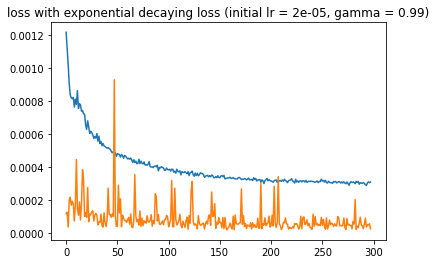

In [62]:
plt.plot(train_losses[0][2:])
plt.plot(test_losses[0][2:])
plt.title(f"loss with exponential decaying loss (initial lr = {learning_rates[0]}, gamma = 0.99)")

Text(0.5, 1.0, 'loss with learning rate = 1e-05')

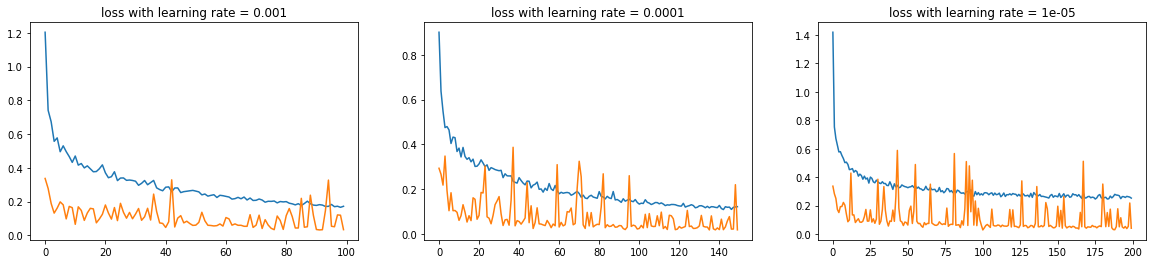

In [20]:
fig,axes = plt.subplots(1,3,figsize=(20,4))

axes[0].plot(train_losses[0][:])
axes[1].plot(train_losses[1][:])
axes[2].plot(train_losses[2][:])
#axes[3].plot(train_losses[3][:])

axes[0].plot(test_losses[0][:])
axes[1].plot(test_losses[1][:])
axes[2].plot(test_losses[2][:])
#axes[2].plot(test_losses[3][:])

axes[0].set_title(f"loss with learning rate = {learning_rates[0]}")
axes[1].set_title(f"loss with learning rate = {learning_rates[1]}")
axes[2].set_title(f"loss with learning rate = {learning_rates[2]}")
#axes[2].set_title(f"loss with learning rate = {learning_rates[3]}")

In [21]:
torch.save(models[1].state_dict(), f'explo/simple_dnn_one_alt_3')